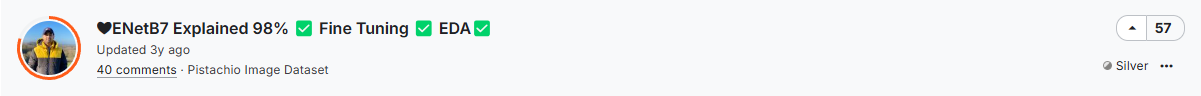
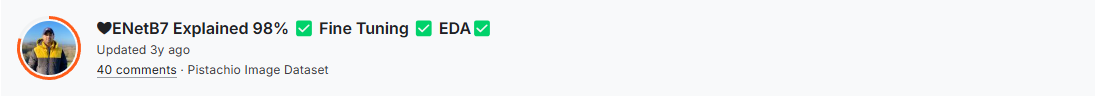

In [24]:
import numpy as np
import pandas as pd

import os
import glob
import pathlib
import cv2
import PIL

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
#加载数据
data_dir = r"D:\code_study\ML_CODE\dataSets\Pistachio_Image_Dataset\Pistachio_Image_Dataset"
data_dir = data_dir.replace('\\', '/')
Total_ImagePath = data_dir + '/*/*.jpg'
#转换成path路径，方便后续提取图像路径名称
data_dir = pathlib.Path(data_dir)

In [26]:
#使用glob获取所有图像
Total_Images = glob.glob(Total_ImagePath)
print("Total number of images:", len(Total_Images))
#将图像路径转换成Series，方便后续读取
Total_Images = pd.Series(Total_Images)

Total number of images: 2148


In [27]:
#使用lambda函数提取图像类别
total_df = pd.DataFrame()
#最后一个是图像名称
#.map是应用当前pd.Series下的所有元素
total_df['FileName'] = Total_Images.map(lambda x: x.split("\\")[-1])
#倒数第二个是类别
total_df['ClassId'] = Total_Images.map(lambda x: x.split("\\")[-2])
#显示前5行
total_df.head()

,FileName,ClassId
0,kirmizi (1).jpg,Kirmizi_Pistachio
1,kirmizi (10).jpg,Kirmizi_Pistachio
2,kirmizi (11).jpg,Kirmizi_Pistachio
3,kirmizi (12).jpg,Kirmizi_Pistachio
4,kirmizi (13).jpg,Kirmizi_Pistachio


In [28]:
class_id_distribution = total_df['ClassId'].value_counts()
class_id_distribution

Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: ClassId, dtype: int64

In [29]:
#分析数据
#显示类别分布
fig = go.Figure(go.Bar(
    x = class_id_distribution.values,
    y = class_id_distribution.index,
    orientation = 'h'
))

fig.update_layout(title = "Data Distribution in Bars", xaxis_title = "Count", yaxis_title = "ClassId",
                  font_size = 15, title_x = 0.45)
fig.show()

In [30]:
#使用饼图去显示分布情况
fig = px.pie(class_id_distribution, values='ClassId',names=total_df['ClassId'].unique(), hole=0.425)
fig.update_layout(title = "Data Distribution in Pie Chart", font_size = 15, title_x = 0.45, 
                  annotations=[dict(text='Pistachio',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size = 15, textinfo='percent')

In [31]:
#分割数据集
#使用splitfloder函数分割数据集
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(0.8, 0.1, 0.1))

In [32]:
train_path = "output/train"
val_path = "output/val"
test_path = "output/test"

class_names = os.listdir(train_path)
class_names_val = os.listdir(val_path)
class_names_test = os.listdir(test_path)
class_names

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [33]:
train_images = glob.glob(train_path + '/*/*.jpg')
print("train_images:", len(train_images))

val_images = glob.glob(val_path + '/*/*.jpg')
print("val_images:", len(val_images))

test_images = glob.glob(test_path + '/*/*.jpg')
print("test_images:", len(test_images))


train_images: 1717
val_images: 214
test_images: 217


In [34]:
#显示数据的分布
random_x = [len(train_images), len(val_images), len(test_images)]
names = ["train_images", "val_images", "test_images"]
fig = px.pie(values=random_x, names=names, hole=0.425)
fig.update_layout(title = "Data Distribution in Pie Chart", font_size = 15, title_x = 0.45, 
                  annotations=[dict(text='Pistachio',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size = 15, textinfo='percent')
fig.show()

In [35]:
train_image_names = pd.Series(train_images)
train_df = pd.DataFrame()
train_df['Filename'] = train_image_names.map(lambda x: x.split("\\")[-1])
train_df['ClassId'] = train_image_names.map(lambda x: x.split("\\")[-2])
train_df.head()

,Filename,ClassId
0,kirmizi (1).jpg,Kirmizi_Pistachio
1,kirmizi (10).jpg,Kirmizi_Pistachio
2,kirmizi (11).jpg,Kirmizi_Pistachio
3,kirmizi (12).jpg,Kirmizi_Pistachio
4,kirmizi (13).jpg,Kirmizi_Pistachio


In [36]:
#显示训练集的类别分布
fig = go.Figure(go.Bar(
    x = train_df['ClassId'].value_counts().values,
    y = train_df['ClassId'].value_counts().index,
    orientation = 'h'
))
fig.update_layout(title = "Train Data Distribution in Bars", xaxis_title = "Count", yaxis_title = "ClassId")
fig.show()

In [37]:
#显示测试数据集的分布
test_images = pd.Series(test_images)
test_df = pd.DataFrame()
test_df['Filename'] = test_images.map(lambda x: x.split("\\")[-1])
test_df['ClassId'] = test_images.map(lambda x: x.split("\\")[-2])
test_df.head()

,Filename,ClassId
0,kirmizi (20).jpg,Kirmizi_Pistachio
1,kirmizi (21).jpg,Kirmizi_Pistachio
2,kirmizi (27).jpg,Kirmizi_Pistachio
3,kirmizi (31).jpg,Kirmizi_Pistachio
4,kirmizi (35).jpg,Kirmizi_Pistachio


In [38]:
fig = go.Figure(go.Bar(
    x = test_df['ClassId'].value_counts().values,
    y = test_df['ClassId'].value_counts().index,
    orientation = 'h'
))
fig.update_layout(title = "Test Data Distribution in Bars")
fig.show()

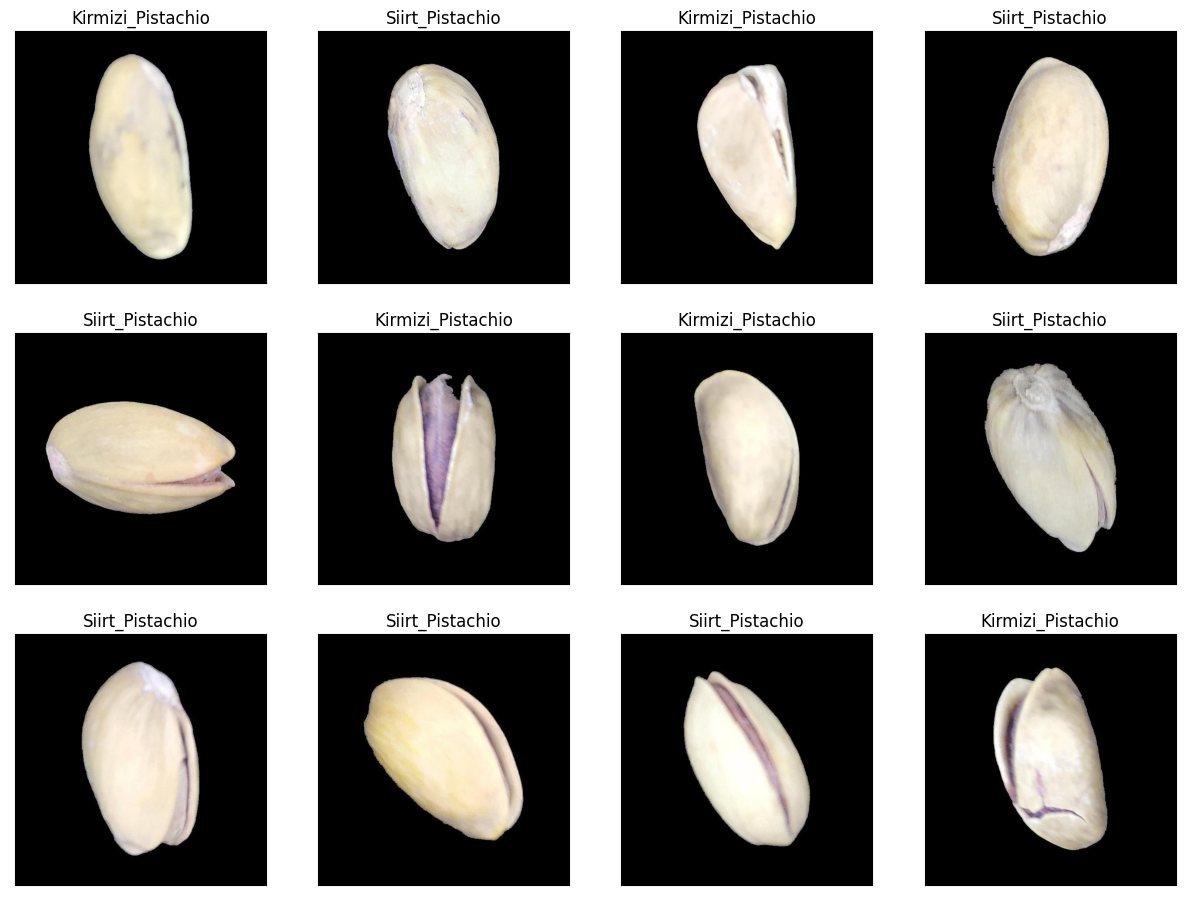

In [39]:
#展示数据
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label_str = plot_df.loc[i, 'ClassId']
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(train_path, label_str, img_name))
    plt.imshow(img)
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, shuffle=True, class_mode='binary')

Found 1717 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [41]:
#加载模型
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [42]:
#修改模型的参数
model.trainable = True
for layer in model.layers[:-15]:
    layer.trainable = False

In [43]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

print_layer_trainable()

False:	input_2
False:	rescaling_1
False:	normalization_1
False:	stem_conv_pad
False:	stem_conv
False:	stem_bn
False:	stem_activation
False:	block1a_dwconv
False:	block1a_bn
False:	block1a_activation
False:	block1a_se_squeeze
False:	block1a_se_reshape
False:	block1a_se_reduce
False:	block1a_se_expand
False:	block1a_se_excite
False:	block1a_project_conv
False:	block1a_project_bn
False:	block2a_expand_conv
False:	block2a_expand_bn
False:	block2a_expand_activation
False:	block2a_dwconv_pad
False:	block2a_dwconv
False:	block2a_bn
False:	block2a_activation
False:	block2a_se_squeeze
False:	block2a_se_reshape
False:	block2a_se_reduce
False:	block2a_se_expand
False:	block2a_se_excite
False:	block2a_project_conv
False:	block2a_project_bn
False:	block2b_expand_conv
False:	block2b_expand_bn
False:	block2b_expand_activation
False:	block2b_dwconv
False:	block2b_bn
False:	block2b_activation
False:	block2b_se_squeeze
False:	block2b_se_reshape
False:	block2b_se_reduce
False:	block2b_se_expand
False:	bl

In [44]:
from tensorflow.keras.layers import Dropout, Flatten, Dense
x = Flatten()(model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=model.input, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
print_layer_trainable()

False:	input_2
False:	rescaling_1
False:	normalization_1
False:	stem_conv_pad
False:	stem_conv
False:	stem_bn
False:	stem_activation
False:	block1a_dwconv
False:	block1a_bn
False:	block1a_activation
False:	block1a_se_squeeze
False:	block1a_se_reshape
False:	block1a_se_reduce
False:	block1a_se_expand
False:	block1a_se_excite
False:	block1a_project_conv
False:	block1a_project_bn
False:	block2a_expand_conv
False:	block2a_expand_bn
False:	block2a_expand_activation
False:	block2a_dwconv_pad
False:	block2a_dwconv
False:	block2a_bn
False:	block2a_activation
False:	block2a_se_squeeze
False:	block2a_se_reshape
False:	block2a_se_reduce
False:	block2a_se_expand
False:	block2a_se_excite
False:	block2a_project_conv
False:	block2a_project_bn
False:	block2b_expand_conv
False:	block2b_expand_bn
False:	block2b_expand_activation
False:	block2b_dwconv
False:	block2b_bn
False:	block2b_activation
False:	block2b_se_squeeze
False:	block2b_se_reshape
False:	block2b_se_reduce
False:	block2b_se_expand
False:	bl

In [45]:
#可视化模型
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
# Image(filename='convnet.png')

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\visualkeras\layered.py:86: UserWarning:

The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.



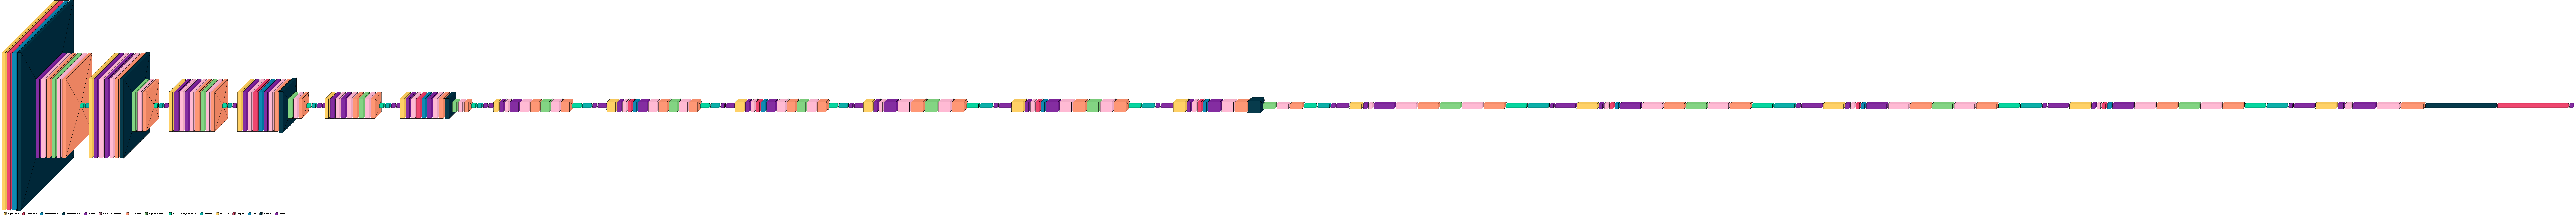

In [46]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

In [50]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=50, verbose=1)

In [51]:
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [52]:
#训练模型
H = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[es, mc])

Epoch 1/100
54/54 [==============================] - 11s 206ms/step - loss: 0.1224 - accuracy: 0.9779 - val_loss: 1.5015 - val_accuracy: 0.8785
Epoch 2/100
54/54 [==============================] - 11s 207ms/step - loss: 0.0925 - accuracy: 0.9802 - val_loss: 1.3293 - val_accuracy: 0.8925
Epoch 3/100
54/54 [==============================] - 11s 209ms/step - loss: 0.0656 - accuracy: 0.9849 - val_loss: 1.9091 - val_accuracy: 0.8224
Epoch 4/100
54/54 [==============================] - 12s 215ms/step - loss: 0.0969 - accuracy: 0.9819 - val_loss: 0.4518 - val_accuracy: 0.9393
Epoch 5/100
54/54 [==============================] - 11s 205ms/step - loss: 0.0882 - accuracy: 0.9814 - val_loss: 0.7049 - val_accuracy: 0.9252
Epoch 6/100
54/54 [==============================] - 11s 206ms/step - loss: 0.1131 - accuracy: 0.9779 - val_loss: 1.5411 - val_accuracy: 0.8832
Epoch 7/100
54/54 [==============================] - 11s 205ms/step - loss: 0.0643 - accuracy: 0.9849 - val_loss: 0.7865 - val_accuracy:

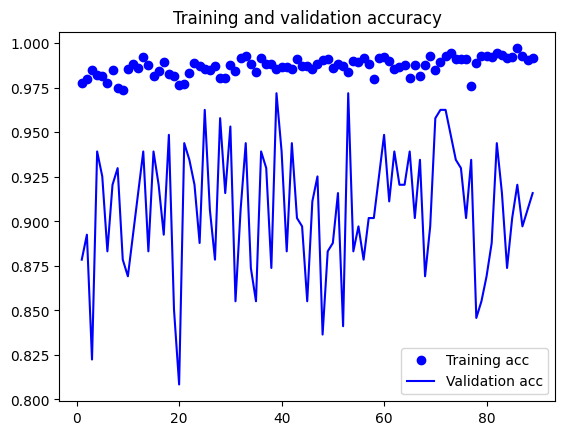

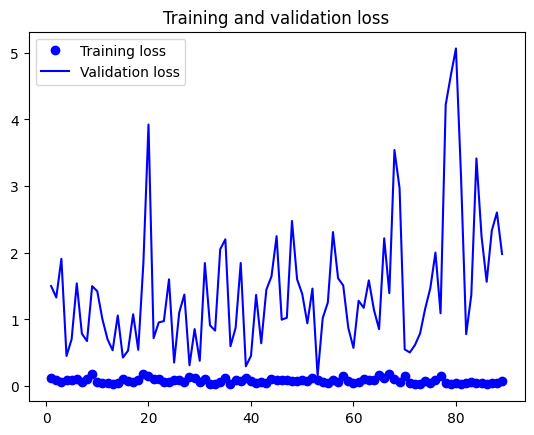

In [53]:
#画出损失曲线
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
#模型评估
test_loss, test_acc = model.evaluate(test_generator, steps = len(test_generator), verbose = 1)
print('Loss: %.3f'%(test_loss * 100.0))
print('Accuracy: %.3f'%(test_acc * 100.0))

7/7 [==============================] - 0s 57ms/step - loss: 1.1286 - accuracy: 0.9355
Loss: 112.862
Accuracy: 93.548


In [57]:
from sklearn.metrics import classification_report, confusion_matrix

y_val = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       124
           1       0.00      0.00      0.00        93

    accuracy                           0.57       217
   macro avg       0.29      0.50      0.36       217
weighted avg       0.33      0.57      0.42       217



c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [59]:
class_indices = test_generator.class_indices
indices = {v:k for k, v in class_indices.items()}
indices

{0: 'Kirmizi_Pistachio', 1: 'Siirt_Pistachio'}

In [60]:
filenames = test_generator.filenames
filenames

['Kirmizi_Pistachio\\kirmizi (20).jpg',
 'Kirmizi_Pistachio\\kirmizi (21).jpg',
 'Kirmizi_Pistachio\\kirmizi (27).jpg',
 'Kirmizi_Pistachio\\kirmizi (31).jpg',
 'Kirmizi_Pistachio\\kirmizi (35).jpg',
 'Kirmizi_Pistachio\\kirmizi (5).jpg',
 'Kirmizi_Pistachio\\kirmizi 1.jpg',
 'Kirmizi_Pistachio\\kirmizi 1002.jpg',
 'Kirmizi_Pistachio\\kirmizi 1021.jpg',
 'Kirmizi_Pistachio\\kirmizi 1029.jpg',
 'Kirmizi_Pistachio\\kirmizi 1045.jpg',
 'Kirmizi_Pistachio\\kirmizi 105.jpg',
 'Kirmizi_Pistachio\\kirmizi 1055.jpg',
 'Kirmizi_Pistachio\\kirmizi 1060.jpg',
 'Kirmizi_Pistachio\\kirmizi 1061.jpg',
 'Kirmizi_Pistachio\\kirmizi 1064.jpg',
 'Kirmizi_Pistachio\\kirmizi 107.jpg',
 'Kirmizi_Pistachio\\kirmizi 1081.jpg',
 'Kirmizi_Pistachio\\kirmizi 109.jpg',
 'Kirmizi_Pistachio\\kirmizi 1095.jpg',
 'Kirmizi_Pistachio\\kirmizi 1102.jpg',
 'Kirmizi_Pistachio\\kirmizi 1106.jpg',
 'Kirmizi_Pistachio\\kirmizi 1113.jpg',
 'Kirmizi_Pistachio\\kirmizi 1115.jpg',
 'Kirmizi_Pistachio\\kirmizi 1143.jpg',
 'Kirmi

In [63]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual'] == val_df['predicted'], 'Same'] = True
val_df.loc[val_df['actual'] != val_df['predicted'], 'Same'] = False
val_df.head()

,filename,actual,predicted,Same
0,Kirmizi_Pistachio\kirmizi (20).jpg,Kirmizi_Pistachio,Kirmizi_Pistachio,True
1,Kirmizi_Pistachio\kirmizi (21).jpg,Kirmizi_Pistachio,Kirmizi_Pistachio,True
2,Kirmizi_Pistachio\kirmizi (27).jpg,Kirmizi_Pistachio,Kirmizi_Pistachio,True
3,Kirmizi_Pistachio\kirmizi (31).jpg,Kirmizi_Pistachio,Kirmizi_Pistachio,True
4,Kirmizi_Pistachio\kirmizi (35).jpg,Kirmizi_Pistachio,Kirmizi_Pistachio,True


In [64]:
val_df = val_df.sample(frac = 1).reset_index(drop=True)


In [88]:
#预测比较
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img_size = 224
def readImage(path):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        image = readImage(f"D:/code_study/ML_CODE/dataSets/Pistachio_Image_Dataset/Pistachio_Image_Dataset/{temp_df.filename[i]}")
        plt.imshow(image)

        plt.title(f'A: {temp_df.actual[i]} P:{temp_df.predicted[i]}')


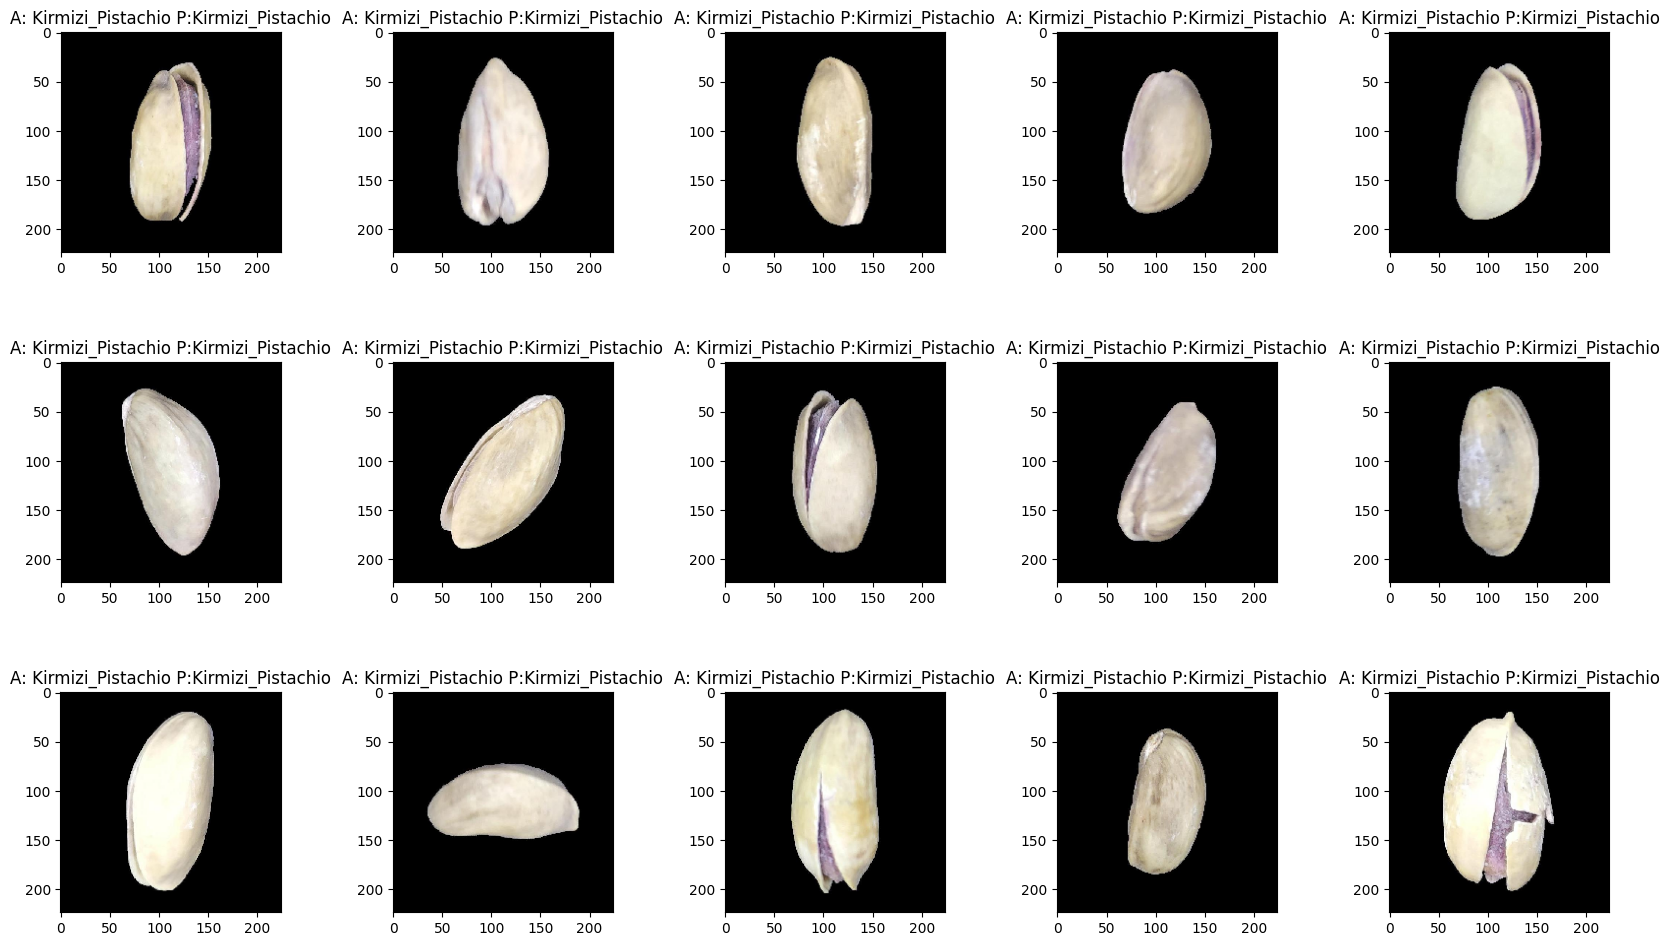

In [90]:
display_images(val_df[val_df['Same']==True])

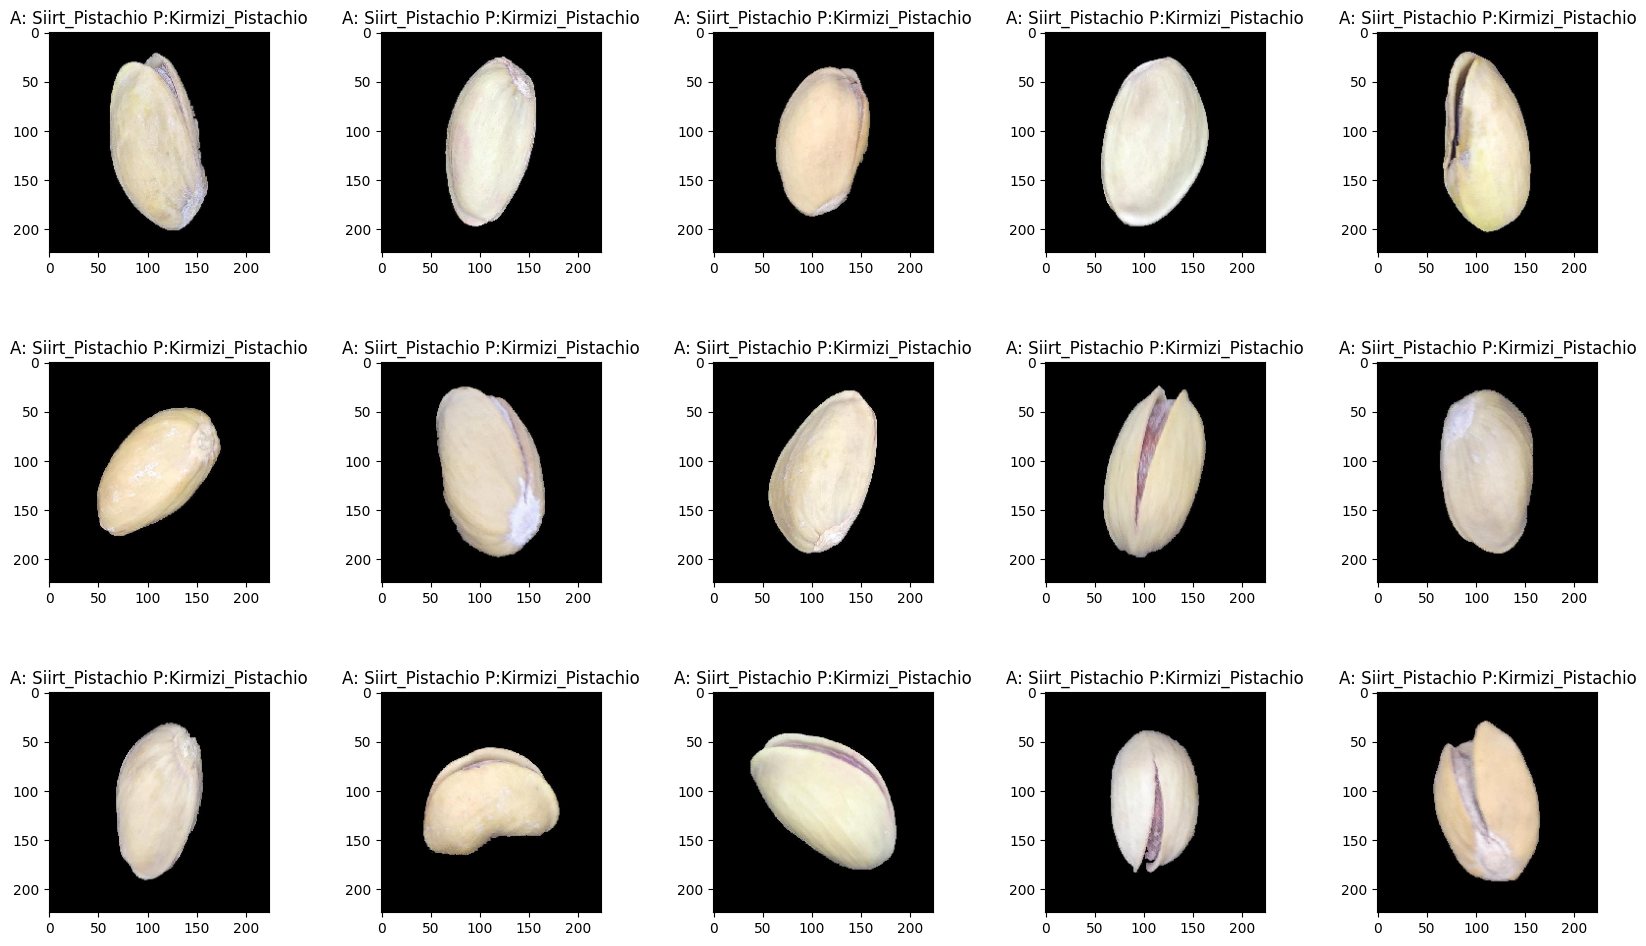

In [91]:
display_images(val_df[val_df['Same'] == False])

In [92]:
#混淆矩阵
cm = confusion_matrix(y_val, y_pred)

In [101]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")

    else:
        print("Confusion matrix, without normalization")
        print(cm)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment = 'center',
        color = "white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[124   0]
 [ 93   0]]


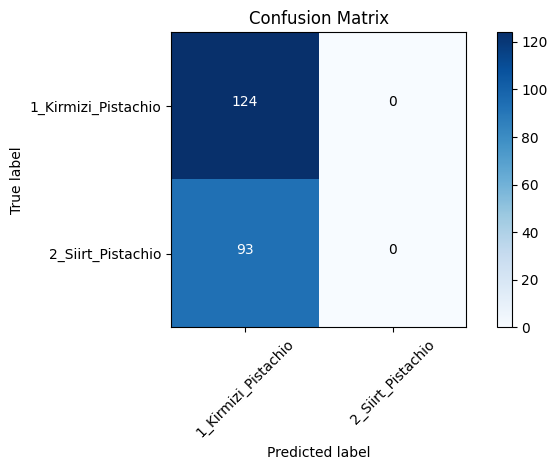

In [102]:
cm_plot_labels = ['1_Kirmizi_Pistachio', '2_Siirt_Pistachio']

plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')